<img src="./logo_UNSAM.jpg" align="right" width="150" /> 

#### Análisis y Procesamiento de Señales

# Trabajo Práctico Nº4: Primeras nociones de estimación espectral.
#### Nombre y Apellido: Matías Galperin, Tomás Quiros

# Introducción Teórica
Al trabajar con señales de duración finita, es necesario aplicar técnicas de ventaneo, que consisten en multiplicar la señal por una ventana temporal con el fin de reducir los efectos de fuga espectral (spectral leakage).  

La elección de la ventana influye directamente en las propiedades estadísticas de los estimadores espectrales. Dos métricas centrales en este contexto son el sesgo (diferencia sistemática entre el valor estimado y el valor real del parámetro) y la varianza (medida de la dispersión de las estimaciones alrededor de su media). Dependiendo de la ventana utilizada, estos indicadores se ven afectados de manera distinta, generando un compromiso inevitable entre resolución en frecuencia, exactitud en la amplitud y estabilidad de las estimaciones.  

De este modo, este trabajo se orienta a analizar el desempeño de distintas ventanas, rectangular, flat-top, Blackman-Harris y Blackman, en la estimación de amplitud y frecuencia de una senoidal inmersa en ruido blanco gaussiano, evaluando el impacto de cada una en términos de sesgo y varianza bajo diferentes relaciones señal–ruido (SNR).  

# Análisis y Desarrollo
Para analizar la varianza y sesgo de las distintas ventanas, se generó una señal senoidal de amplitud $a_0 = 2$ y frecuencia central $\Omega_0 = \pi/2$, a la cual se le añadió un corrimiento aleatorio $f_r \sim U(-2,2)$ y ruido blanco gaussiano $n_a(n) \sim N(0,\sigma^2)$, con $\sigma$ ajustado para obtener relaciones señal–ruido (SNR) de 3 dB y 10 dB.  

Se implementaron estimadores para la amplitud y la frecuencia de la senoidal a partir de la transformada discreta de Fourier, aplicando diferentes ventanas: Rectangular, Flat-top, Blackman-Harris y Blackman. La estimación de la amplitud se corrigió mediante la ganancia coherente de cada ventana, mientras que la frecuencia se obtuvo como la posición del máximo en el espectro.  

A través de un procedimiento Monte Carlo con $M=200$ realizaciones, se calcularon el sesgo y la varianza de los estimadores en cada caso. Los resultados evidenciaron las diferencias en el desempeño de cada ventana: la Flat-top tendió a mejorar la estimación de amplitud al reducir el sesgo, mientras que la Blackman-Harris ofreció mayor estabilidad en la estimación de la frecuencia, disminuyendo la varianza frente al ruido y la fuga espectral.  

# Conclusiones
A partir de los resultados obtenidos puede concluirse que no existe una ventana universalmente óptima para la estimación espectral. Cada ventana presenta un valor diferente de sesgo y varianza, tanto en la estimación de la amplitud como en la de la frecuencia. Por lo tanto, la selección de la ventana debe hacerse considerando el contexto de la aplicación, priorizando cuál de los parámetros resulta más crítico estimar con precisión. En aplicaciones donde la amplitud es clave, conviene elegir ventanas que reduzcan el sesgo en este aspecto, mientras que en aquellas donde la frecuencia es determinante, se debe dar prioridad a minimizar la varianza en la estimación de dicho parámetro.

---

### Indicar una opción:

Resolví la tarea con seguridad

**Resolví la tarea, pero tengo dudas**

Resolví la tarea,pero no entendí bien

No pude resolverla y no entendí

### Responder:

*¿Qué aprendiste al hacer esta tarea?*

**Aprendí a cómo utilizar python para aplicaciones con distintos tipos de señales.**

*¿Qué te quedó claro? ¿Qué te sigue costando?*

**Me sigue costando pensar en las longitudes de cada parámetro en las funciones para lograr multiplicarlas entre sí o graficarlas, pero con más práctica va a ir mejorando. Tampoco tengo del todo claro el uso de todas las herramientas aún**

### Indicar si se utilizó IA:

**Sí, usé chatGPT, Qwen, Deepseek, Gemini, otra.**

No usé IA.

### En caso afirmativo, indicar una opción o varias:

Escritura

**Código**

Conceptos teorícos

Gráficos

Conclusiones

In [1]:
import numpy as np
from numpy.fft import rfft, rfftfreq
from scipy.signal import windows
from math import pi, sqrt
import matplotlib.pyplot as plt

# ================== Parámetros globales (consigna) ==================
# Semilla reproducible para Monte Carlo
generador_azar = np.random.default_rng(123)

# N: cantidad de muestras por realización (señal x[n])
N_muestras = 1000

# M: cantidad de realizaciones Monte Carlo
M_realizaciones = 200

# Frecuencia digital central (rad/muestra)
Omega0_rad = np.pi/2

# a0: amplitud real de la senoide (según consigna)
a0 = 2.0

# Lista de SNRs (en dB) a evaluar
SNR_dB_lista = [3, 10]

# Ventanas a probar (nombre -> constructor). Usamos scipy.signal.windows
ventanas_dict = {
    "Rectangular":      lambda N: np.ones(N),
    "Flat-top":         lambda N: windows.flattop(N, sym=False),
    "Blackman-Harris":  lambda N: windows.blackmanharris(N, sym=False),
    "Blackman":         lambda N: windows.blackman(N, sym=False),  # otra a elección
}

def ganancia_coherente(ventana: np.ndarray) -> float:
    """CG = (1/N) * sum w[n]. Corrige la atenuación de la ventana en el tono coherente."""
    return ventana.mean()

def potencia_seno(amplitud: float) -> float:
    """Potencia de un seno puro: a^2/2."""
    return amplitud**2 / 2

def var_ruido_para_snr(P_senal: float, SNR_dB: float) -> float:
    """Varianza del ruido blanco gaussiano para alcanzar la SNR deseada."""
    P_ruido = P_senal / (10**(SNR_dB/10))
    return P_ruido

def bin_desde_Omega0(N: int, Omega0: float) -> int:
    """Devuelve el índice k del semiespectro (rFFT) más cercano a Omega0."""
    k = int(np.round((Omega0/(2*np.pi)) * N))
    return int(np.clip(k, 0, N//2))

k0 = bin_desde_Omega0(N_muestras, Omega0_rad)
omegas_rad = 2*np.pi * rfftfreq(N_muestras, d=1.0)  # eje de frecuencia en rad/muestra

def una_realizacion(SNR_dB: float):
    """
    Genera una realización x[n] = a0*sin(Omega1*n) + n_a(n), con:
      - fr ~ U(-2,2) → Omega1 = Omega0 + fr*(2π/N)
      - n_a(n) ~ N(0, σ^2) ajustado a la SNR pedida
    Devuelve:
      - a_estim_por_ventana: dict nombre_ventana -> estimación de amplitud (bin fijo k0, corrigiendo CG)
      - Omega_estim_por_ventana: dict nombre_ventana -> estimación de frecuencia (pico del espectro)
      - Omega1_real: frecuencia verdadera de esta realización
    """
    # Corrimiento fr uniforme en [-2, 2] (en bins fraccionales)
    fr_desajuste = generador_azar.uniform(-2, 2)
    Omega1_real = Omega0_rad + fr_desajuste * (2*np.pi/N_muestras)

    n = np.arange(N_muestras)
    senal_pura = a0 * np.sin(Omega1_real * n)

    # Ruido para alcanzar la SNR deseada
    P_senal = potencia_seno(a0)
    var_ruido = var_ruido_para_snr(P_senal, SNR_dB)
    ruido = generador_azar.normal(0.0, np.sqrt(var_ruido), size=N_muestras)

    x = senal_pura + ruido

    a_estim_por_ventana = {}
    Omega_estim_por_ventana = {}

    for nombre, construir_ventana in ventanas_dict.items():
        w = construir_ventana(N_muestras)
        x_ventaneada = x * w

        X = rfft(x_ventaneada)
        modulo_X = np.abs(X)

        # --- Estimador de amplitud (bin fijo k0) ---
        CG = ganancia_coherente(w)
        a_estim = (2.0 / (N_muestras * CG)) * modulo_X[k0]
        a_estim_por_ventana[nombre] = float(a_estim)

        # --- Estimador de frecuencia (pico espectral) ---
        k_pico = int(np.argmax(modulo_X))
        Omega_estim = float(omegas_rad[k_pico])
        Omega_estim_por_ventana[nombre] = Omega_estim

    return a_estim_por_ventana, Omega_estim_por_ventana, float(Omega1_real)


def correr_montecarlo(SNR_dB: float, M: int = 200):
    """
    Ejecuta M realizaciones y calcula, por ventana:
      - Sesgo y varianza de la estimación de amplitud
      - Sesgo y varianza de la estimación de frecuencia
    Devuelve:
      - resultados_amplitud: dict ventana -> (sesgo_ampl, var_ampl)
      - resultados_frecuencia: dict ventana -> (sesgo_freq, var_freq)
    """
    historial_a_estim = {nombre: [] for nombre in ventanas_dict}
    historial_Omega_estim = {nombre: [] for nombre in ventanas_dict}
    historial_Omega_real = []

    for _ in range(M):
        a_est, Om_est, Om_real = una_realizacion(SNR_dB)
        for nombre in ventanas_dict:
            historial_a_estim[nombre].append(a_est[nombre])
            historial_Omega_estim[nombre].append(Om_est[nombre])
        historial_Omega_real.append(Om_real)

    historial_Omega_real = np.array(historial_Omega_real)

    resultados_amplitud = {}
    resultados_frecuencia = {}

    for nombre in ventanas_dict:
        # --- Amplitud ---
        a_arr = np.array(historial_a_estim[nombre])
        media_a = a_arr.mean()
        var_a = a_arr.var(ddof=0)
        sesgo_a = media_a - a0
        resultados_amplitud[nombre] = (sesgo_a, var_a)

        # --- Frecuencia ---
        Om_arr = np.array(historial_Omega_estim[nombre])
        error_freq = Om_arr - historial_Omega_real
        sesgo_f = error_freq.mean()
        var_f = error_freq.var(ddof=0)
        resultados_frecuencia[nombre] = (sesgo_f, var_f)

    return resultados_amplitud, resultados_frecuencia


def imprimir_tabla_amplitud(resultados_amplitud: dict, snr_db: float):
    print(f"\n=== SNR = {snr_db} dB | AMPLITUD ===")
    print(f"{'Ventana':17s} | {'Sesgo':>12s} | {'Varianza':>12s}")
    print("-"*50)
    for nombre, (sesgo, var) in resultados_amplitud.items():
        print(f"{nombre:17s} | {sesgo:+12.6f} | {var:12.4e}")


def imprimir_tabla_frecuencia(resultados_frecuencia: dict, snr_db: float):
    print(f"\n=== SNR = {snr_db} dB | FRECUENCIA (rad/muestra) ===")
    print(f"{'Ventana':17s} | {'Sesgo':>12s} | {'Varianza':>12s}")
    print("-"*50)
    for nombre, (sesgo, var) in resultados_frecuencia.items():
        print(f"{nombre:17s} | {sesgo:+12.6e} | {var:12.4e}")


# Se agrega para los gráficos
# Guardamos los resultados de todas las SNR para apilar métricas
resultados_todos = {}  # {snr: (resultados_amplitud, resultados_frecuencia)}
for snr_db in SNR_dB_lista:
    resultados_todos[snr_db] = correr_montecarlo(snr_db, M=M_realizaciones)

nombres_ventanas = list(ventanas_dict.keys())


def apilar_metricas(indice_resultado: int, orden_ventanas: list):
    """Devuelve (snrs, matriz_sesgo, matriz_var) con filas=ventanas, cols=SNRs.
       indice_resultado: 0=amplitud, 1=frecuencia
    """
    snrs = list(resultados_todos.keys())
    sesgo = np.zeros((len(orden_ventanas), len(snrs)))
    var = np.zeros((len(orden_ventanas), len(snrs)))
    for j, snr_db in enumerate(snrs):
        res = resultados_todos[snr_db][indice_resultado]
        for i, nombre in enumerate(orden_ventanas):
            sesgo[i, j] = res[nombre][0]
            var[i, j] = res[nombre][1]
    return snrs, sesgo, var

snrs_amp, sesgo_amp, var_amp = apilar_metricas(0, nombres_ventanas)
snrs_freq, sesgo_freq, var_freq = apilar_metricas(1, nombres_ventanas)


# ================== Gráficos ==================
def graficar_barras_agrupadas(y_matriz, titulo, etiqueta_y, etiquetas_x, snrs, usar_log=False):
    """Grafica barras agrupadas. y_matriz: (n_ventanas x n_snrs)."""
    n_ventanas, n_snrs = y_matriz.shape
    x = np.arange(n_ventanas)
    ancho = 0.35 if n_snrs == 2 else 0.8/n_snrs

    fig, ax = plt.subplots(figsize=(9, 4.8))
    for j in range(n_snrs):
        ax.bar(x + (j-(n_snrs-1)/2)*ancho, y_matriz[:, j], ancho, label=f"SNR = {snrs[j]} dB")
    ax.set_xticks(x, etiquetas_x, rotation=10)
    ax.set_title(titulo)
    ax.set_ylabel(etiqueta_y)
    ax.grid(True, axis='y', linestyle='--', alpha=0.4)
    if usar_log:
        ax.set_yscale('log')
    ax.legend()
    plt.tight_layout()
    plt.show()

# ==========================================
# Gráficos de señales con ruido (tiempo)
# ==========================================

def generar_senal_con_ruido(SNR_dB: float):
    """
    Genera UNA realización x[n] = a0*sin(Omega1*n) + ruido_gaussiano
    usando los parámetros globales de la consigna.
    Devuelve: (n, x, senal_pura, ruido, Omega1_real, fr_desajuste)
    """
    # Corrimiento fr ~ U(-2,2) -> Omega1 = Omega0 + fr*(2π/N)
    fr_desajuste = generador_azar.uniform(-2, 2)
    Omega1_real = Omega0_rad + fr_desajuste * (2*np.pi / N_muestras)

    n = np.arange(N_muestras)
    senal_pura = a0 * np.sin(Omega1_real * n)

    # Ruido gaussiano con var ajustada a la SNR
    P_senal = potencia_seno(a0)
    var_ruido = var_ruido_para_snr(P_senal, SNR_dB)
    ruido = generador_azar.normal(0.0, np.sqrt(var_ruido), size=N_muestras)

    x = senal_pura + ruido
    return n, x, senal_pura, ruido, Omega1_real, fr_desajuste


def graficar_una_realizacion(SNR_dB: float, muestras_mostrar: int = 400):
    """
    Grafica una realización: x[n] (ruidosa) vs la senoide pura.
    """
    n, x, senal_pura, ruido, Omega1_real, fr = generar_senal_con_ruido(SNR_dB)

    fig, ax = plt.subplots(figsize=(10, 4.5))
    ax.plot(n[:muestras_mostrar], senal_pura[:muestras_mostrar], lw=2, label="Senoide pura")
    ax.plot(n[:muestras_mostrar], x[:muestras_mostrar], lw=1, alpha=0.9, label="Señal con ruido")
    ax.set_title(f"Una realización – SNR = {SNR_dB} dB  |  Ω₁ ≈ {Omega1_real:.4f} rad/muestra  (fr={fr:+.2f})")
    ax.set_xlabel("n (muestra)")
    ax.set_ylabel("Amplitud")
    ax.grid(True, linestyle="--", alpha=0.4)
    ax.legend()
    plt.tight_layout()
    plt.show()

    # Histograma del ruido para ver gaussianidad
    fig, ax = plt.subplots(figsize=(6.5, 4.0))
    ax.hist(ruido, bins=40, density=True, alpha=0.8, edgecolor="k")
    ax.set_title(f"Histograma del ruido (SNR = {SNR_dB} dB)")
    ax.set_xlabel("Valor del ruido")
    ax.set_ylabel("Densidad")
    ax.grid(True, linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.show()

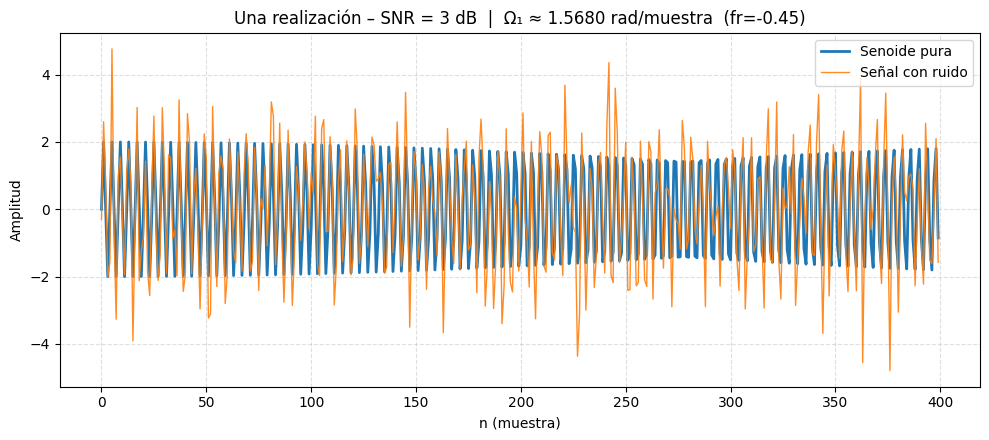

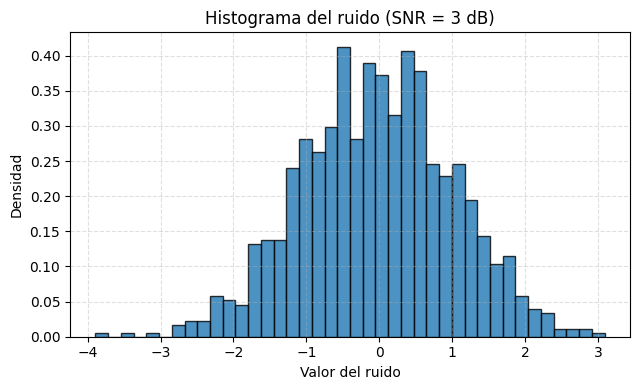

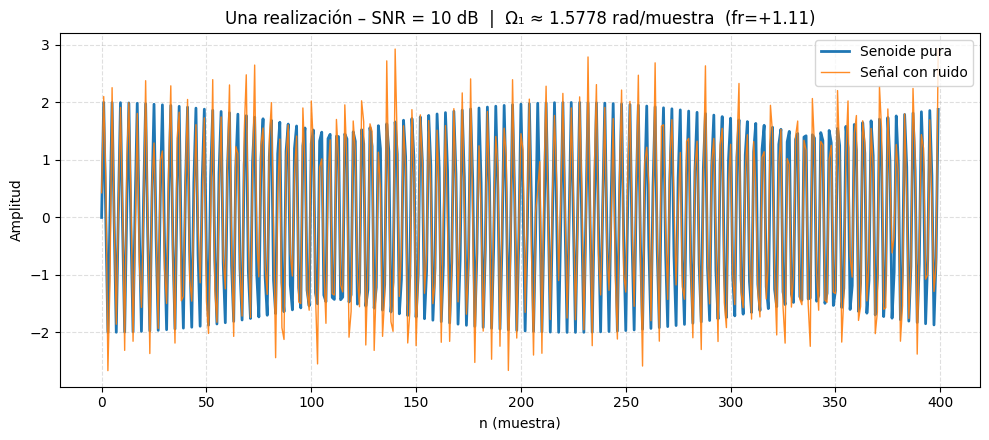

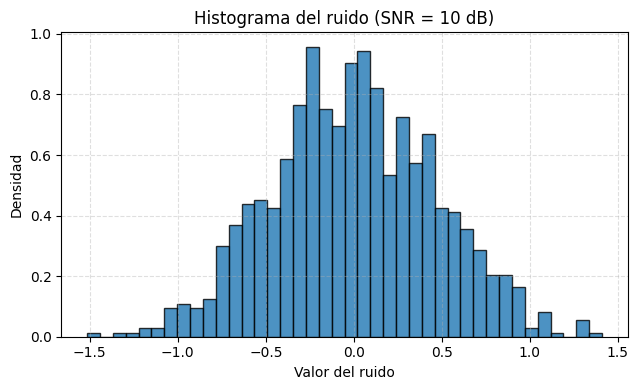

In [4]:
#Gráficos de señal con ruido e histogramas
# Una realización (tiempo + histograma de ruido)
graficar_una_realizacion(SNR_dB=3, muestras_mostrar=400)

# Con 10 dB
graficar_una_realizacion(SNR_dB=10, muestras_mostrar=400)

### Análisis de los gráficos  

En la primera figura (SNR = 3 dB) se observa que la señal con ruido presenta una alta perturbación respecto de la senoidal pura, lo que dificulta distinguir la forma de la onda. El histograma del ruido confirma la distribución gaussiana con mayor dispersión, consistente con la menor relación señal–ruido.  

En la segunda figura (SNR = 10 dB) la señal con ruido se aproxima mucho más a la senoidal pura, ya que la potencia del ruido es menor. El histograma del ruido muestra una campana más concentrada en torno a cero, reflejando la reducción en la varianza del ruido respecto al caso de 3 dB.  


=== SNR = 3 dB | AMPLITUD ===
Ventana           |        Sesgo |     Varianza
--------------------------------------------------
Rectangular       |    -1.299025 |   4.1729e-01
Flat-top          |    -0.151338 |   4.3956e-02
Blackman-Harris   |    -0.675602 |   2.4672e-01
Blackman          |    -0.821006 |   3.2996e-01

=== SNR = 3 dB | FRECUENCIA (rad/muestra) ===
Ventana           |        Sesgo |     Varianza
--------------------------------------------------
Rectangular       | -1.425281e-04 |   3.1014e-06
Flat-top          | +1.402152e-04 |   6.9834e-06
Blackman-Harris   | -7.969624e-05 |   3.1678e-06
Blackman          | -1.425281e-04 |   3.1194e-06

=== SNR = 10 dB | AMPLITUD ===
Ventana           |        Sesgo |     Varianza
--------------------------------------------------
Rectangular       |    -1.260735 |   4.4276e-01
Flat-top          |    -0.178420 |   4.5301e-02
Blackman-Harris   |    -0.703920 |   2.8219e-01
Blackman          |    -0.847783 |   3.7750e-01

=== SNR = 10

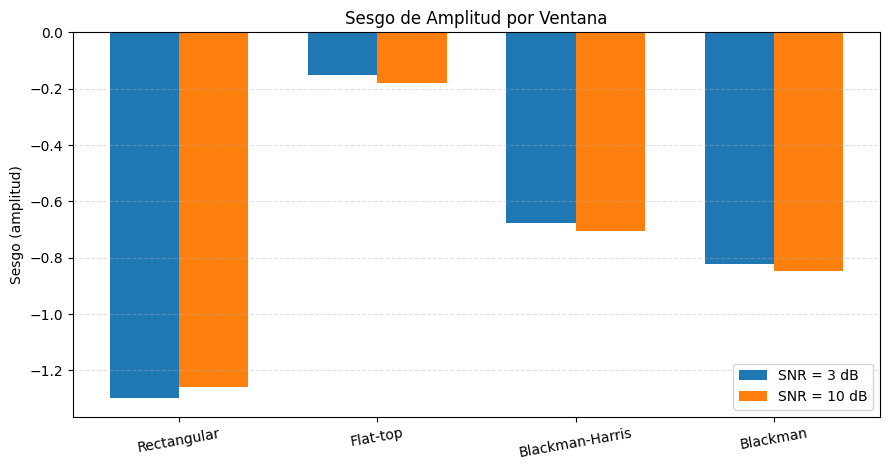

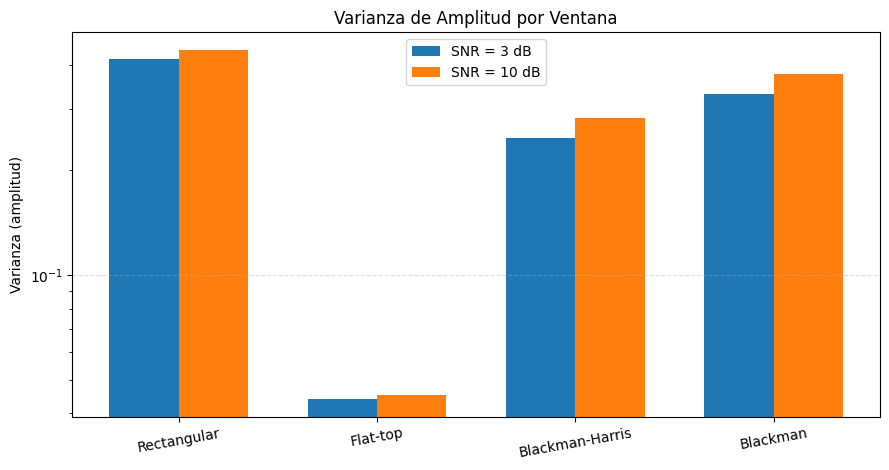

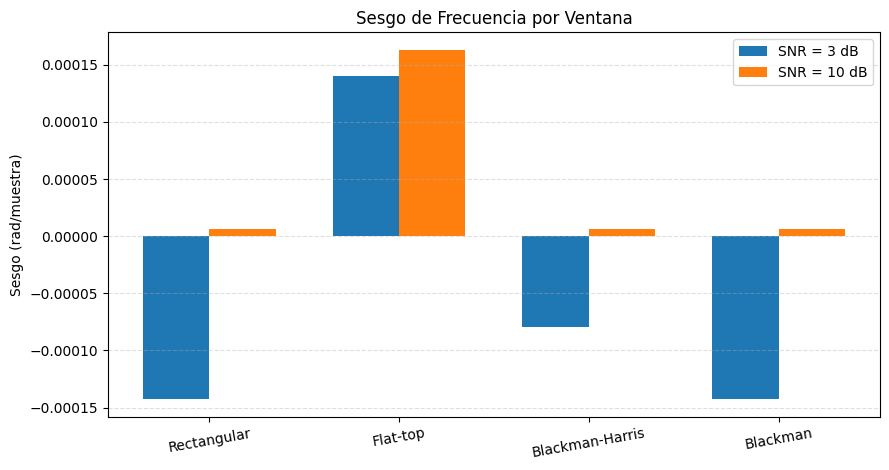

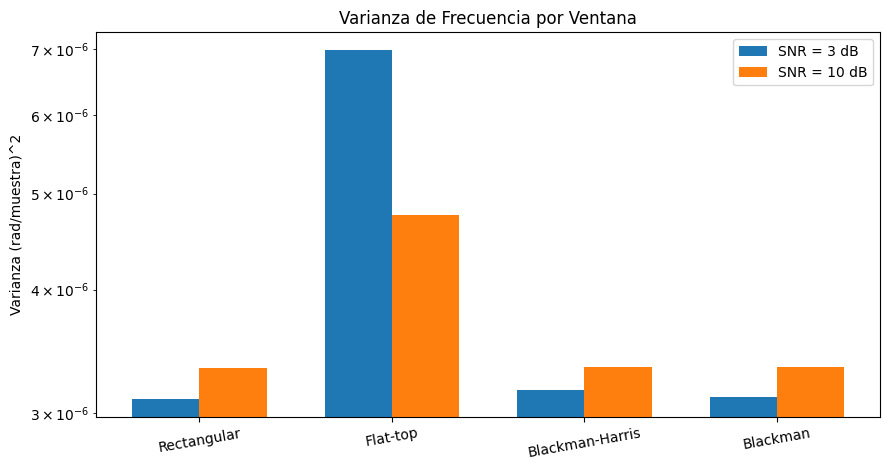

In [6]:
#Tablas
for snr_db in SNR_dB_lista:
    res_amp, res_freq = resultados_todos[snr_db]
    imprimir_tabla_amplitud(res_amp, snr_db)
    imprimir_tabla_frecuencia(res_freq, snr_db)
    
# 1) Sesgo de amplitud
graficar_barras_agrupadas(
    sesgo_amp,
    "Sesgo de Amplitud por Ventana",
    "Sesgo (amplitud)",
    nombres_ventanas,
    snrs_amp,
    usar_log=False
)

# 2) Varianza de amplitud (escala log recomendada)
graficar_barras_agrupadas(
    var_amp,
    "Varianza de Amplitud por Ventana",
    "Varianza (amplitud)",
    nombres_ventanas,
    snrs_amp,
    usar_log=True
)

# 3) Sesgo de frecuencia
graficar_barras_agrupadas(
    sesgo_freq,
    "Sesgo de Frecuencia por Ventana",
    "Sesgo (rad/muestra)",
    nombres_ventanas,
    snrs_freq,
    usar_log=False
)

# 4) Varianza de frecuencia (escala log recomendada)
graficar_barras_agrupadas(
    var_freq,
    "Varianza de Frecuencia por Ventana",
    "Varianza (rad/muestra)^2",
    nombres_ventanas,
    snrs_freq,
    usar_log=True
)

### Análisis de resultados 
En la estimación de amplitud se observa que la ventana Rectangular presenta el mayor sesgo negativo y la mayor varianza, lo que la hace poco adecuada para este parámetro. La ventana Flat-top muestra el sesgo más reducido y la menor varianza en ambos niveles de SNR, confirmando que está optimizada para mediciones de amplitud. Las ventanas Blackman y Blackman-Harris mejoran el comportamiento respecto de la Rectangular, pero no alcanzan la precisión de la Flat-top.  

En la estimación de frecuencia, todas las ventanas presentan sesgos muy pequeños (del orden de $10^{-4}$ rad/muestra o menores). Las varianzas también resultan bajas, con valores cercanos a $10^{-6}$. Esto indica que la estimación de la frecuencia es robusta frente al ruido y relativamente insensible a la ventana elegida, aunque la Flat-top muestra una varianza algo mayor.  

En conjunto, los resultados muestran que la elección de la ventana depende del parámetro que se priorice: la Flat-top es la más adecuada para estimación de amplitud, mientras que para frecuencia no se observan diferencias significativas entre las ventanas.  